# Analysis of Wall Street Bets Subreddit vs Meme Stock Prices
## Team: TheDAO
### Members:
- Colin Chan Wei Hua        A0199771J
- Leu Pei Lin Denise        A0221004H
- Png Zheng Jie, Sebastian  A0201782L
- Yak Jun Yan James         A0218097X
- Yeoh An Ni                A0225614L

## Importing Relevant Libraries

In [173]:
import datetime
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from emoji import get_emoji_regexp
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud, STOPWORDS

## 1. Data wrangling
Performed data wrangling of reddit dataset by converting timestamps into dates and removing emojis, punctuations, tags, links, NaN values and empty strings.

### [Reddit Dataset](https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts)

In [2]:
# Import data
reddit = pd.read_csv('./Datasets/reddit_wsb.csv')

# Data cleaning functions
emoji_pattern = get_emoji_regexp()

def remove_emojis(text):
    return re.sub(emoji_pattern, '', text)

def remove_punctuations(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def remove_tags(text):
    return re.sub('@[\w]*', '', text)

def remove_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

# Applies a list of functions to a dataframe and returns the resultant dataframe
def data_cleaning(df, func_list):
    result = df.copy()
    for f in func_list:
        result = result.apply(f)
    return result

# List of data cleaning functions
cleaning_func = [(lambda x : remove_emojis(x)), (lambda x: x.lower()), (lambda x: remove_URLs(x)), 
                 (lambda x: remove_tags(x)), (lambda x: remove_punctuations(x)), (lambda x: x.strip())]

# Change Timestamp to date format
reddit['timestamp'] = pd.to_datetime(reddit['timestamp']).dt.date
reddit.rename(columns = {'timestamp': 'date'}, inplace = True)

# Removes any rows with dates outside of 2021
reddit = reddit[reddit['date'] >= datetime.date(2021, 1, 1)]

# Extract out relevant data - the date, thread title and body only
reddit_body = reddit[['date', 'body']].copy()

# Data Cleaning
reddit_body = reddit_body[reddit_body['body'].notna()] # removes NaN values
reddit_body['body'] = data_cleaning(reddit_body['body'], cleaning_func)

# Removes rows with empty strings
reddit_body = reddit_body[reddit_body['body'] != '']

# Resets row index
reddit_body = reddit_body.reset_index(drop = True)

reddit_body.head()

,date,body
0,2021-01-28,the ceo of nasdaq pushed to halt trading to gi...
1,2021-01-28,hedgefund whales are spreading disinfo saying ...
2,2021-01-28,life isnt fair my mother always told me that w...
3,2021-01-28,i believe right now is one of those rare oppor...
4,2021-01-28,you guys are champs gme who would have thought...


### [Meme Stock Data](https://www.investing.com/)

In [3]:
# Import data
amc_data = pd.read_csv('./Datasets/AMC Historical Data.csv')
bb_data = pd.read_csv('./Datasets/BB Historical Data.csv')
clov_data = pd.read_csv('./Datasets/CLOV Historical Data.csv')
gme_data = pd.read_csv('./Datasets/GME Historical Data.csv')

# Data cleaning functions
def clean_meme_df(df, stock_name):
    # Convert date string to date format
    df['Date'] = pd.to_datetime(df['Date']).dt.date

    # Rename columns to reflect stock name
    df.rename(columns = {'Date': 'date', 'Price': stock_name + ' Price'}, inplace = True)

    # Sort data frame by dates
    df.sort_values(by = 'date', inplace = True)
    
    # Resets row index
    df = df.reset_index(drop = True)
    
    return df.iloc[:, 0:2] 
    
# Merging meme stock data
dfs = [gme_data, amc_data, bb_data, clov_data]
stock_names = ['GME', 'AMC', 'BB', 'CLOV']
meme_data = reduce(lambda df1, df2: pd.merge(df1, df2, on = 'date', how = 'left'), 
                   [clean_meme_df(x, y) for x, y in zip(dfs, stock_names)])

meme_data.head()

,date,GME Price,AMC Price,BB Price,CLOV Price
0,2021-01-28,193.60,8.63,14.65,14.07
1,2021-01-29,325.00,13.26,14.10,13.95
2,2021-02-01,225.00,13.30,14.63,13.81
3,2021-02-02,90.00,7.82,11.55,13.97
4,2021-02-03,92.41,8.97,12.00,13.95


## 2. Wordcloud of Top 100 Words in WSB Thread Bodies.

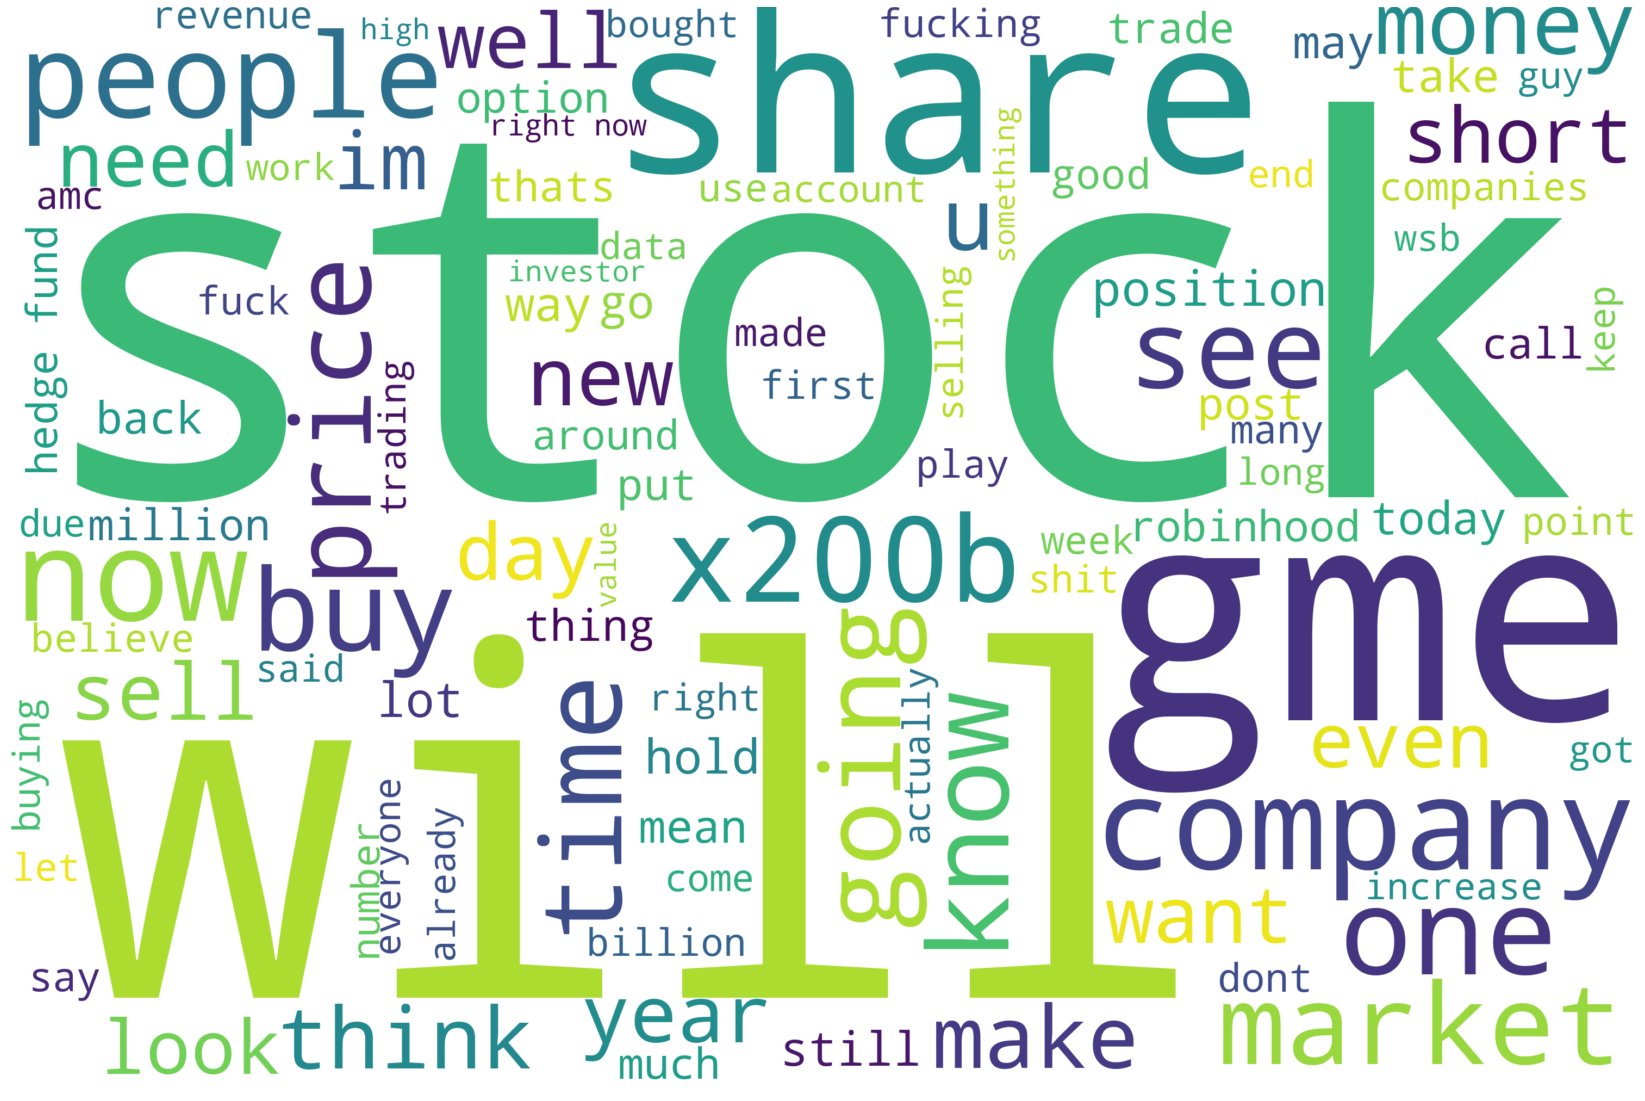

In [3]:
def createWordCloud(text):
    # Generates a word cloud image
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                          max_words = 100, stopwords = STOPWORDS).generate(text)

    # Displays the wordcloud image
    plt.figure(figsize = (30,20))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

# Combining bodies of all threads 
body_text = ' '.join(body for body in reddit_body['body'])

# Create word cloud from all thread bodies
createWordCloud(body_text)

## 3.Top 30 Words in the WSB Thread Bodies

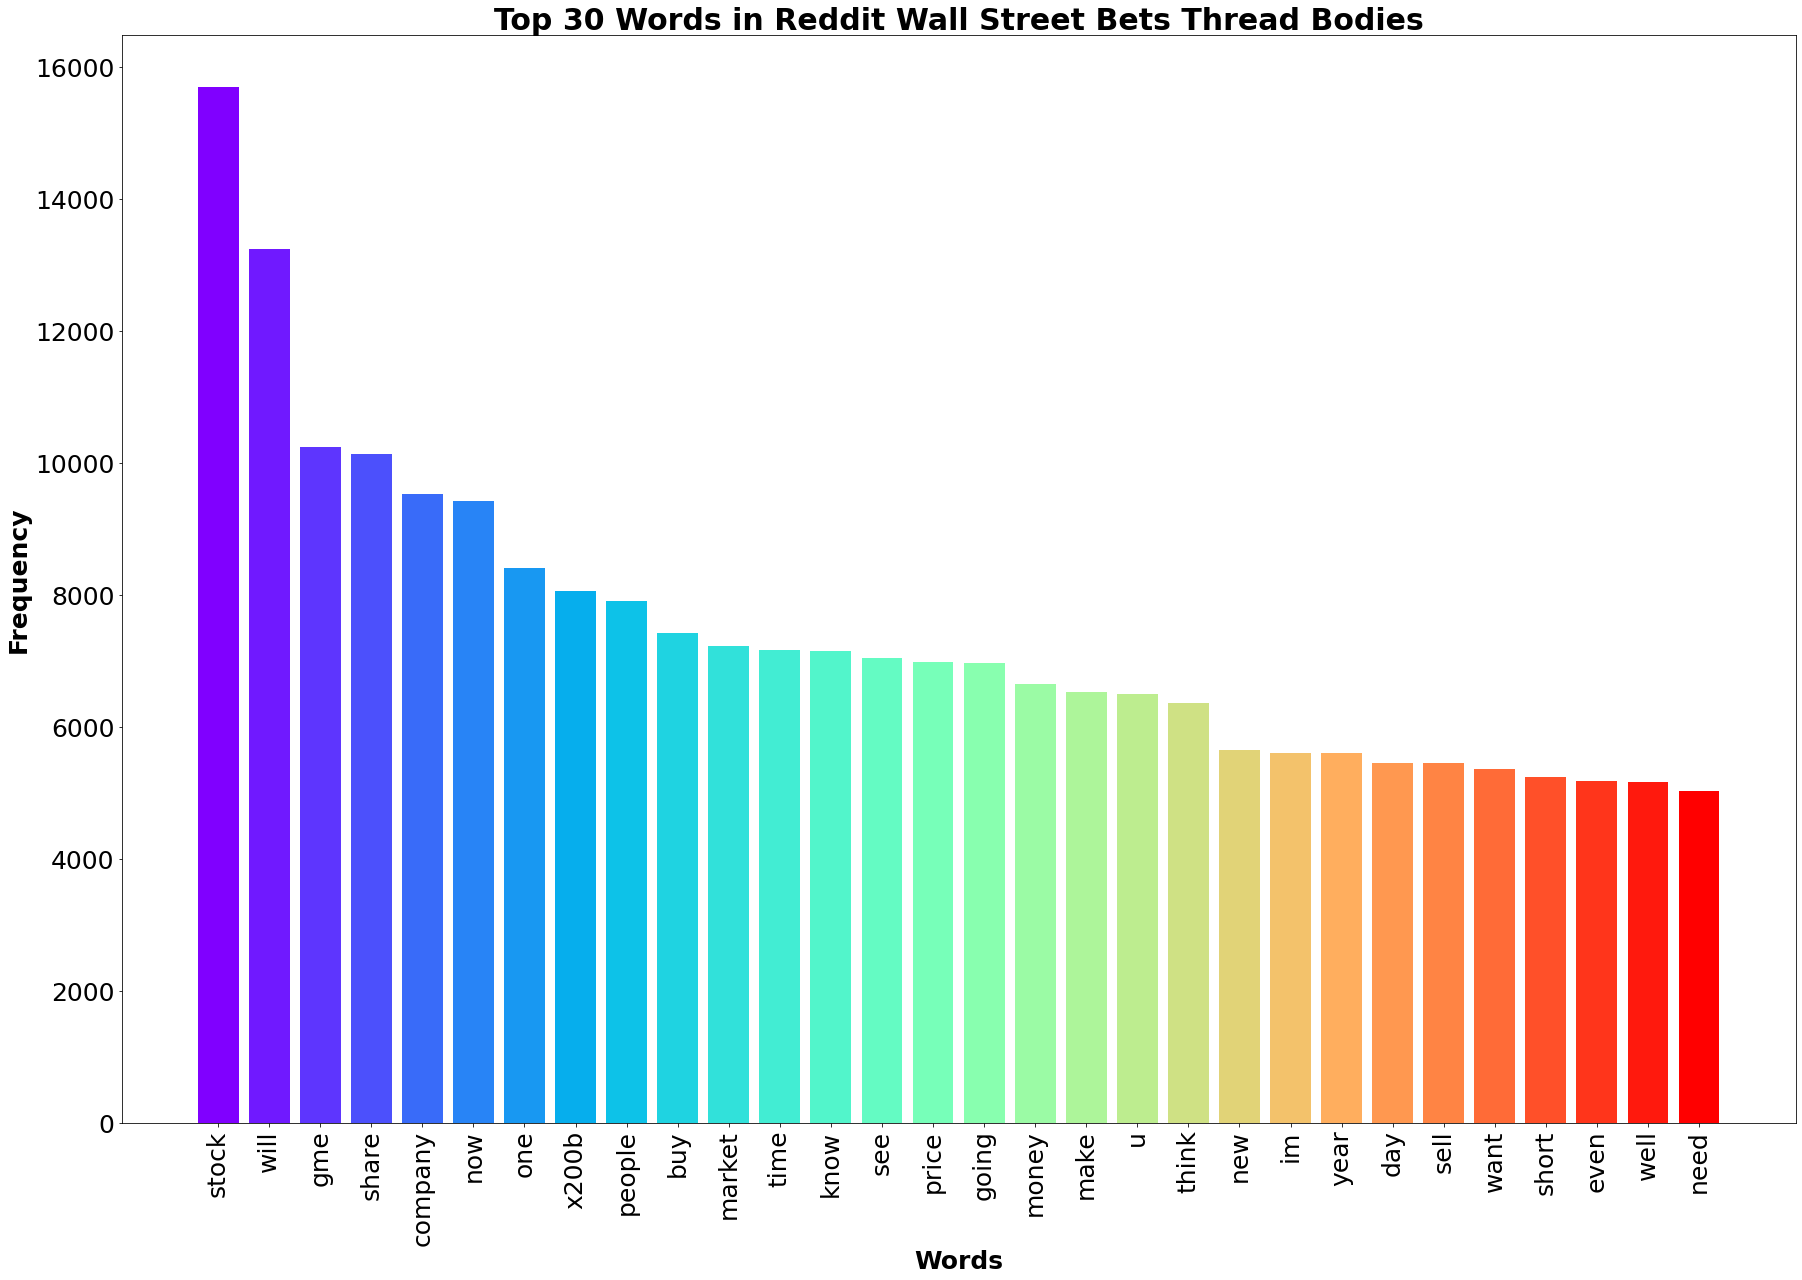

In [4]:
# Process all thread bodies into a dictionary of words to frequency
body_word_to_freq = WordCloud(stopwords = STOPWORDS).process_text(body_text)

# Get top 30 words by their frequency
body_word_to_freq_top30 = dict(sorted(body_word_to_freq.items(), key = lambda item: item[1], reverse = True)[:30])

# Plot bar chart of top 30 words
plt.figure(figsize = (30,20))
plt.bar(*zip(*body_word_to_freq_top30.items()), color = plt.cm.rainbow(np.linspace(0, 1, 30)))
plt.title("Top 30 Words in Reddit Wall Street Bets Thread Bodies", fontsize = 30, fontweight = "bold")
plt.xticks(fontsize = 25, rotation = 90)
plt.yticks(fontsize = 25)
plt.xlabel("Words", fontsize = 25, fontweight = "bold")
plt.ylabel("Frequency", fontsize = 25, fontweight = "bold")
plt.show()

## 4. Sentiment Analysis of Thread Bodies
Sentiment Analysis is conducted using the VADER (Valence Aware Dictionary for Sentiment Reasoner) Sentiment Analysis (VSA). VSA assigns each word or phrase a score and combines all individual segments in a sentence to give four scores: positive, neutral, negative, and compound. The scores for each component indicate the strength of their respective directions, while the compound score is the normalized overall score for the input

In [16]:
# Conducting sentiment analysis using VADER model 
sia = SentimentIntensityAnalyzer()

def addSentimentAnalysis(df, columnName):
    # Creates new column in the input dataframe
    columns = {col: 0 for col in ['negative', 'neutral', 'positive', 'compound']}
    df.assign(**columns)
    
    for i in range(len(df.index)):
        sentence = df[columnName][i]
        scores = sia.polarity_scores(sentence)

        df.loc[i, 'negative'] = scores.get('neg')
        df.loc[i, 'positive'] = scores.get('pos')
        df.loc[i, 'neutral'] = scores.get('neu')
        df.loc[i, 'compound'] = scores.get('compound')

addSentimentAnalysis(reddit_body, 'body')
reddit_body.head()

,date,body,negative,positive,neutral,compound,sentiment
0,2021-01-28,the ceo of nasdaq pushed to halt trading to gi...,0.054,0.084,0.862,0.7854,1.0
1,2021-01-28,hedgefund whales are spreading disinfo saying ...,0.000,0.056,0.944,0.7784,1.0
2,2021-01-28,life isnt fair my mother always told me that w...,0.172,0.068,0.760,-0.9927,-1.0
3,2021-01-28,i believe right now is one of those rare oppor...,0.082,0.153,0.765,0.8271,1.0
4,2021-01-28,you guys are champs gme who would have thought...,0.068,0.120,0.812,0.9384,1.0


The sentiments are then grouped by dates, filtered by individual stocks (GME, AMC, BB, CLOV) and combined into a single dataframe that is exported as a csv file.

In [86]:
# Creates a dataframe with average sentiments grouped by dates
def filter_df(df, columnName, strToFilter):
    suffix = re.sub('\|.+', '', strToFilter)
    rdf = (df[df[columnName].str.contains(r'\b{0}\b'.format(strToFilter))].groupby('date')
                                                                          .agg({'negative': ['count', ('negative_mean', 'mean')],
                                                                                'positive': [('positive_mean', 'mean')],
                                                                                'neutral': [('neutral_mean', 'mean')],
                                                                                'compound': [('compound_mean', 'mean')]})
                                                                          .add_suffix('_body' + ('' if not suffix else '_' + suffix))
                                                                          .reset_index())
    
    rdf.columns = rdf.columns.droplevel(0)
    rdf = rdf.rename(columns = {'':'date'})
    return (rdf)

# Strings to filter the dataframe
amc_words = 'amc'
bb_words = 'bb|blackberry|black berry'
clov_words = 'clov|clover'
gme_words = 'gme|gamestop|game stop|gamestonks'

# Filtering dataframe by individual stock ticker symbols
amc_body = filter_df(reddit_body, 'body', amc_words)
bb_body = filter_df(reddit_body, 'body', bb_words)
clov_body = filter_df(reddit_body, 'body', clov_words)
gme_body = filter_df(reddit_body, 'body', gme_words)

# Main dataframes
reddit_body_daily = filter_df(reddit_body, 'body', '')

# Merging all dataframes
dfs = [reddit_body_daily, gme_body, amc_body, bb_body, clov_body]
reddit_wsb_daily = reduce(lambda df1, df2: pd.merge(df1, df2, on = 'date', how = 'left'), dfs)

# Merging sentiments of threads with meme stock prices
reddit_meme_combined = pd.merge(meme_data, reddit_wsb_daily, on = 'date', how = 'inner')

# Resets row index
reddit_meme_combined = reddit_meme_combined.reset_index(drop = True)

# Export daily aggregated data to csv
reddit_meme_combined.to_csv("./Datasets/reddit_wsb_daily.csv", index = False)

reddit_meme_combined.head()

,date,GME Price,AMC Price,BB Price,CLOV Price,count_body,negative_mean_body,positive_mean_body,neutral_mean_body,compound_mean_body,...,count_body_bb,negative_mean_body_bb,positive_mean_body_bb,neutral_mean_body_bb,compound_mean_body_bb,count_body_clov,negative_mean_body_clov,positive_mean_body_clov,neutral_mean_body_clov,compound_mean_body_clov
0,2021-01-28,193.60,8.63,14.65,14.07,684,0.089819,0.095503,0.813212,0.049073,...,63.0,0.081778,0.083810,0.834476,0.024211,NaN,NaN,NaN,NaN,NaN
1,2021-01-29,325.00,13.26,14.10,13.95,9034,0.089565,0.093308,0.816350,0.005164,...,623.0,0.080437,0.087231,0.832313,0.020259,NaN,NaN,NaN,NaN,NaN
2,2021-02-01,225.00,13.30,14.63,13.81,319,0.075276,0.114342,0.810364,0.379849,...,34.0,0.072118,0.107500,0.820441,0.508288,NaN,NaN,NaN,NaN,NaN
3,2021-02-02,90.00,7.82,11.55,13.97,351,0.081479,0.111168,0.804507,0.220087,...,23.0,0.077957,0.124826,0.797217,0.506204,NaN,NaN,NaN,NaN,NaN
4,2021-02-03,92.41,8.97,12.00,13.95,675,0.082336,0.114529,0.803127,0.232041,...,27.0,0.064259,0.119519,0.816148,0.465878,2.0,0.0265,0.1105,0.8635,0.9857


## 5.  Average Sentiments vs Meme Stock Prices
This section will be appended separately in another file.

## 6. Number of WSB Threads vs Meme Stock Prices

[]

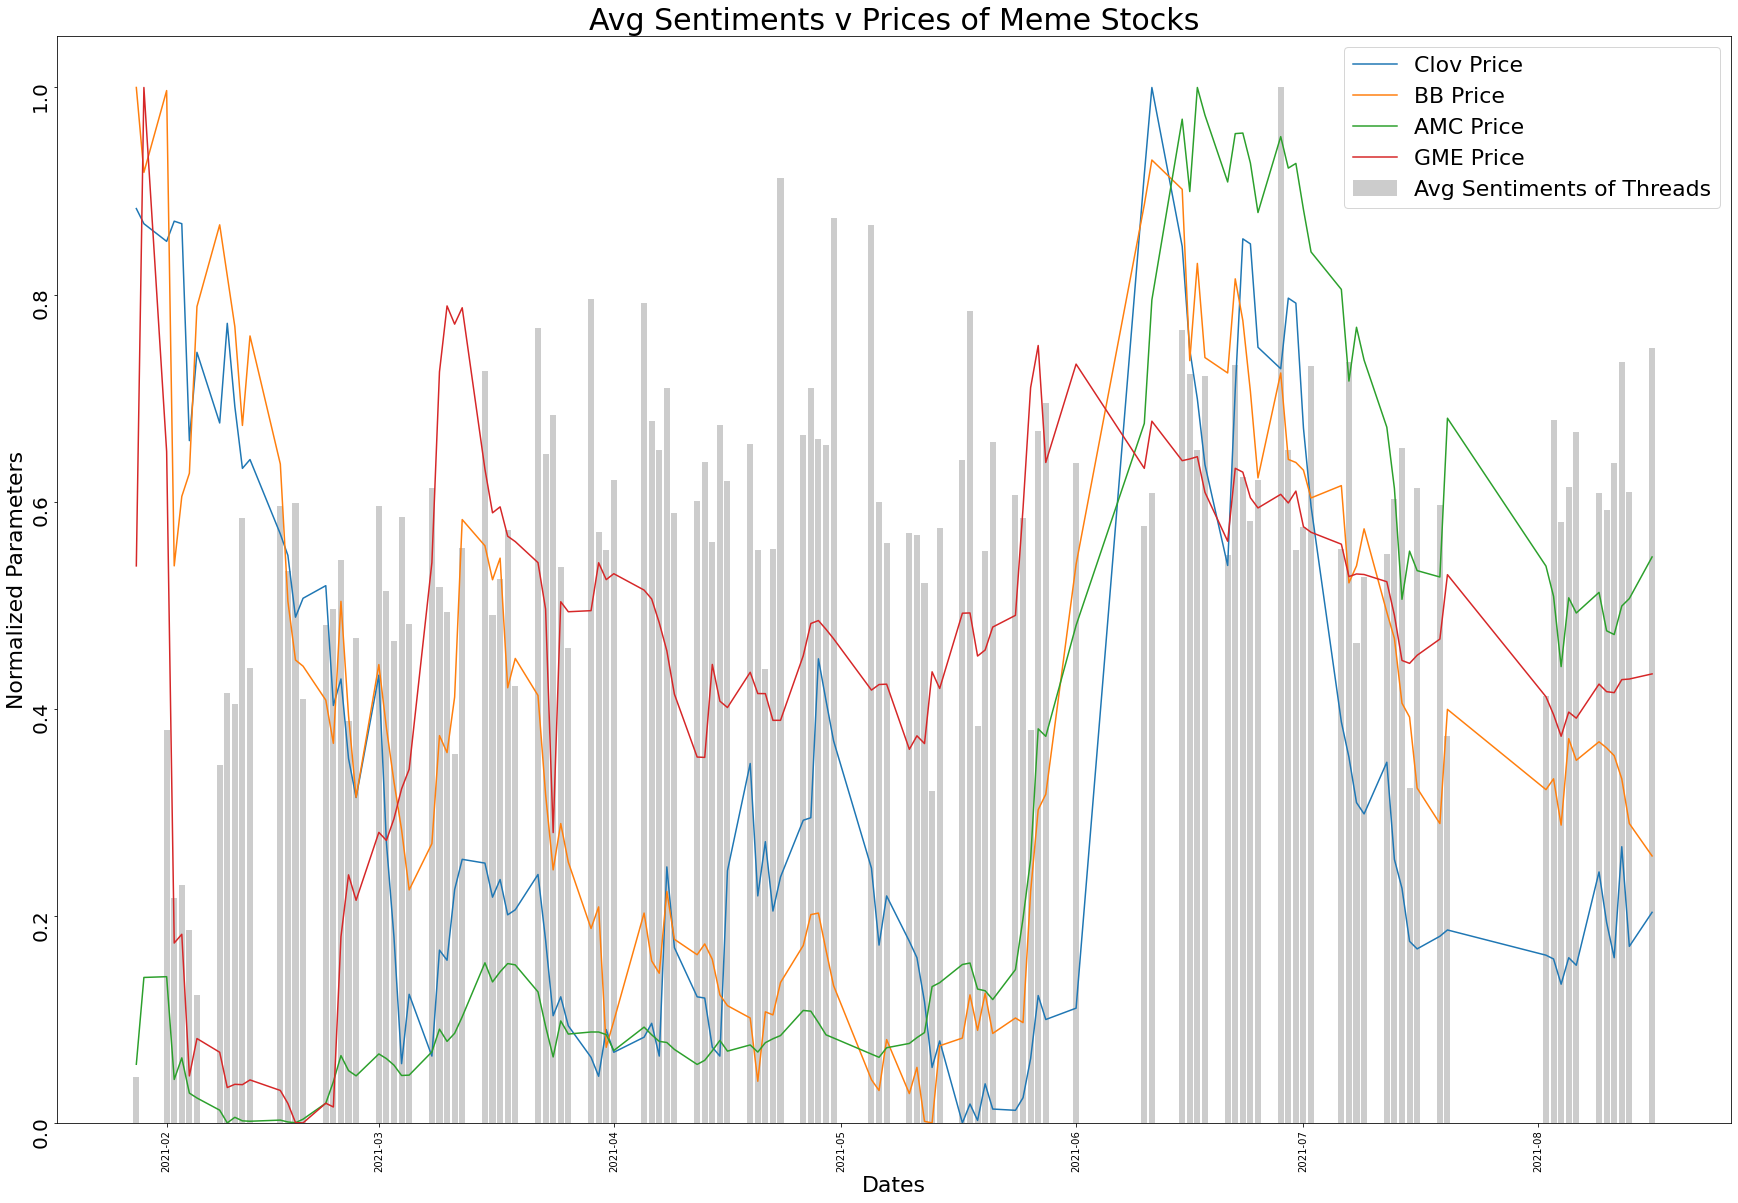

In [164]:
data = reddit_meme_combined[['date', 'count_body', 'compound_mean_body', 'CLOV Price', 'BB Price', 'AMC Price', 'GME Price']].copy()
data = data[(data[['date', 'count_body', 'compound_mean_body', 'CLOV Price', 'BB Price', 'AMC Price', 'GME Price']] != 0).all(axis=1)]
data = data.dropna()

plt.figure(figsize = (30,20))

plt.plot(data['date'], normalize_data(data['CLOV Price']), label = 'Clov Price')
plt.plot(data['date'], normalize_data(data['BB Price']), label = 'BB Price')
plt.plot(data['date'], normalize_data(data['AMC Price']), label = 'AMC Price')
plt.plot(data['date'], normalize_data(data['GME Price']), label = 'GME Price')
plt.bar(data['date'], normalize_data(data['compound_mean_body']),alpha = 0.2, label = 'Avg Sentiments of Threads', color = 'k')


plt.xticks(fontsize=10, rotation = 90)

plt.yticks(fontsize=20, rotation = 90)
plt.xlabel("Dates", fontsize = 22)

plt.ylabel("Normalized Parameters", fontsize = 22)
plt.legend(fontsize = 22)
plt.title("Avg Sentiments v Prices of Meme Stocks", fontsize = 30)
plt.plot()

## 7. Proportion of Threads vs Meme Stock Prices 

In [98]:
# Selecting relevant data from thread body only
df = reddit_wsb_daily[["date", "count_body", "count_body_gme", 
                       "count_body_amc", "count_body_bb","count_body_clov"]].copy()

df.rename(columns = {"count_body":"Total", "count_body_gme":"GME", "count_body_amc":"AMC",
                     "count_body_bb":"BB", "count_body_clov":"CLOV"}, inplace = True)

# Replace NA with 0
df.fillna(value = 0, inplace = True)
df["Others"] = df["Total"] - df.iloc[:,2:5].sum(axis=1)

# Display new data
df

,date,Total,GME,AMC,BB,CLOV,Others
0,2021-01-28,684,255.0,114.0,63.0,0.0,252.0
1,2021-01-29,9034,2507.0,1011.0,623.0,0.0,4893.0
2,2021-01-30,648,363.0,87.0,49.0,0.0,149.0
3,2021-01-31,426,279.0,53.0,37.0,0.0,57.0
4,2021-02-01,319,215.0,48.0,34.0,0.0,22.0
...,...,...,...,...,...,...,...
171,2021-08-12,35,1.0,0.0,1.0,1.0,33.0
172,2021-08-13,31,2.0,1.0,1.0,2.0,27.0
173,2021-08-14,16,1.0,1.0,0.0,2.0,14.0
174,2021-08-15,17,0.0,1.0,0.0,0.0,16.0


In [126]:
# Generates a dataframe for a period of dates
def generate_frame(start_date, end_date, df):
    df_new = df[(df['date'] >= np.datetime64(start_date)) & (df['date'] <= np.datetime64(end_date))].copy()
    df_new = df_new.drop("date", axis=1)
    df_new = df_new.sum()
    df_new = df_new/df_new["Total"] * 100
    df_new = df_new.drop("Total")
    return (df_new)

# Plots a stacked bar chart
def plot_stacked_bar(df):
    ax = df.plot(kind="bar", stacked = True, figsize = (10, 10))
    ax.set_ylabel("Percentage of Threads", fontsize = 14)
    ax.set_xlabel("Dates", fontsize = 14)
    ax.set_title("Proportion of Threads", fontsize = 20, pad = 15)
    ax.legend(fontsize = 12, loc = 'upper right')
    plt.xticks(fontsize = 9, rotation = 0) 
    plt.yticks(fontsize = 12)
    
    plt.show()
    
frames = pd.concat([generate_frame("2021-04-24", "2021-04-30", df), 
                    generate_frame("2021-05-01", "2021-05-08", df), 
                    generate_frame("2021-05-09", "2021-05-16", df), 
                    generate_frame("2021-05-17", "2021-05-24", df), 
                    generate_frame("2021-05-25", "2021-05-31", df),
                    generate_frame("2021-06-01", "2021-06-08", df),
                    generate_frame("2021-06-09", "2021-06-16", df),
                    generate_frame("2021-06-17", "2021-06-24", df),
                    generate_frame("2021-06-25", "2021-07-01", df),
                    generate_frame("2021-07-02", "2021-07-09", df)], axis=1)

results = frames.transpose().rename(index = {0: "24 Apr - 30 Apr",
                                             1: "1 May - 8 May",
                                             2: "9 May - 16 May",
                                             3: "17 May - 24 May",
                                             4: "25 May - 31 May",
                                             5: "1 June - 8 June",
                                             6: "9 June - 16 June",
                                             7: "9 Jun - 16 Jun",
                                             8: "17 Jun - 24 Jun", 
                                             9: "25 Jun - 01 Jul",
                                             10: "02 Jul - 09 Jul"})

results

,GME,AMC,BB,CLOV,Others
24 Apr - 30 Apr,15.584416,5.194805,2.597403,4.545455,76.623377
1 May - 8 May,15.920398,5.970149,4.975124,4.477612,73.134328
9 May - 16 May,10.909091,5.818182,2.181818,4.000000,81.090909
17 May - 24 May,8.374384,3.940887,1.477833,0.492611,86.206897
25 May - 31 May,10.891089,13.861386,5.445545,0.000000,69.801980
1 June - 8 June,12.500000,12.500000,6.250000,0.000000,68.750000
9 June - 16 June,17.162471,14.645309,7.780320,9.382151,60.411899
9 Jun - 16 Jun,7.100592,8.875740,5.719921,4.142012,78.303748
17 Jun - 24 Jun,7.142857,6.168831,5.844156,3.246753,80.844156
25 Jun - 01 Jul,5.952381,6.746032,5.158730,4.365079,82.142857


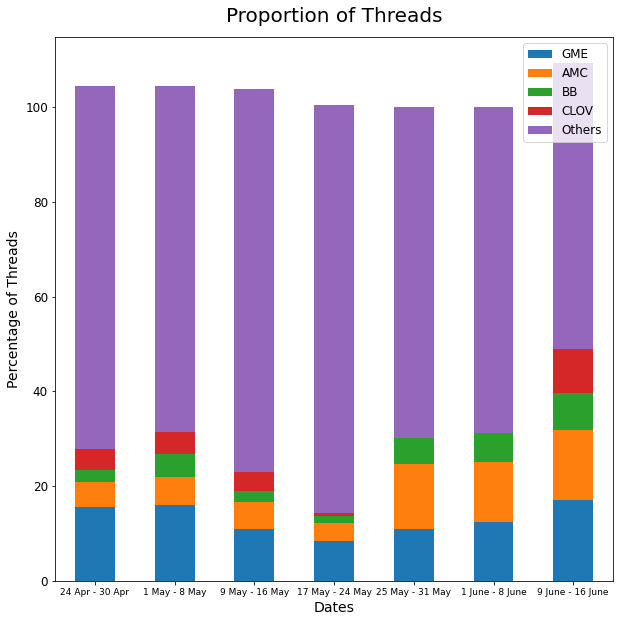

In [127]:
plot_stacked_bar(results.iloc[0:7:,:])

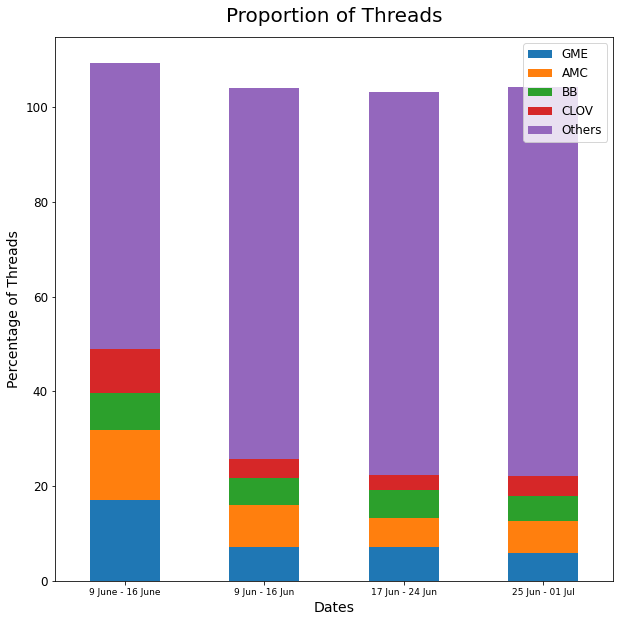

In [128]:
plot_stacked_bar(results.iloc[6:10,:])

## 8. Mean Compound Sentiments Across Meme Stocks

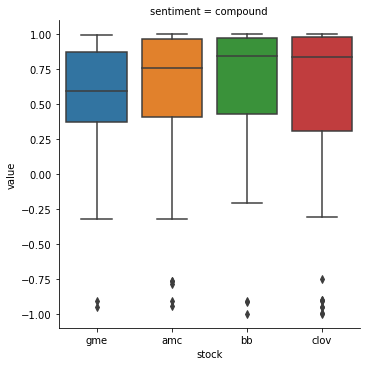

In [110]:
# Get mean thread body compound sentiment of individual stocks
compound = reddit_wsb_daily.iloc[:, np.r_[10, 15, 20, 25]]

# Convert dataframe from wide to long format
compound_long = compound.melt(var_name = 'sentiment')

# Add column to identify stock
compound_long['stock'] = compound_long['sentiment'].apply(lambda x: re.sub('.+_mean_body_', '', x))

# Clean sentiment column
compound_long['sentiment'] = compound_long['sentiment'].apply(lambda x: re.sub('_.+', '', x))

# Drop NaN rows
compound_long = compound_long.dropna(subset = ['value'])

# Plot catplot
sns.catplot(data = compound_long, x = 'stock', y = 'value', col = 'sentiment', kind = 'box', col_wrap = 1)

## 9. Correlation between Average Sentiment of all WSB Threads vs Respective Stock Prices

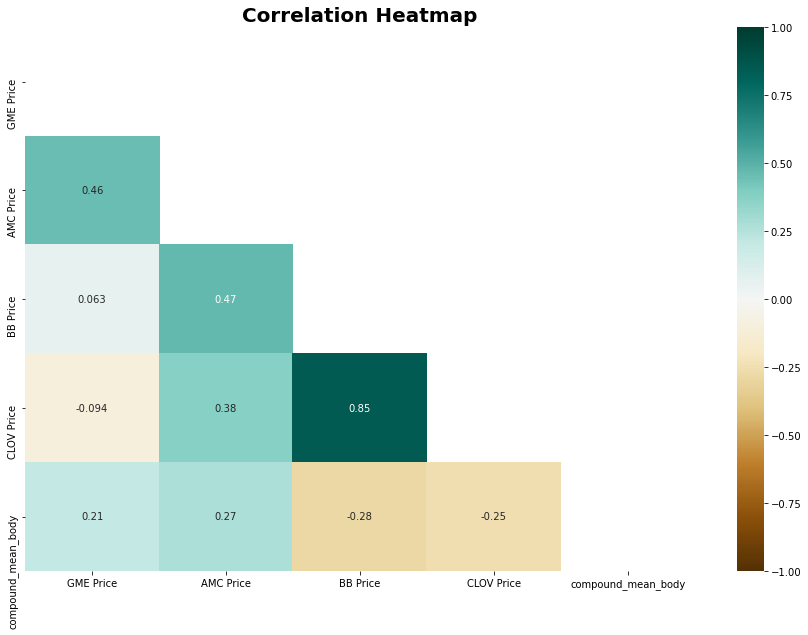

In [137]:
# Get correlation dataframe
reddit_corr = reddit_meme_combined.iloc[:, np.r_[1:5, 9]].dropna().corr()

# Generate mask for upper triangle
mask = np.triu(np.ones_like(reddit_corr, dtype = bool))

# Plot correlation heatmap
plt.figure(figsize = (15, 10))
heatmap = sns.heatmap(reddit_corr, vmin = -1, vmax = 1, cmap = 'BrBG', mask = mask, annot = True)
heatmap.set_title("Correlation Heatmap", fontsize = 20, fontweight = 'bold')
plt.show()

In [143]:
# Create object for the class
linear_regressor = LinearRegression()
x = reddit_meme_combined['compound_mean_body'].values.reshape(-1,1)

def plot_corr(stock_name):
    y = reddit_meme_combined[(stock_name + ' Price')].values.reshape(-1,1)
    plt.scatter(x,y)
    linear_regressor.fit(x, y)  # perform linear regression
    z = linear_regressor.predict(x)  # make predictions
    plt.plot(x,z, color = 'red')
    plt.xlabel('Avg Sentiment')

    plt.ylabel('Price of ' + stock_name)
    plt.title('Avg Sentiments v Price of ' + stock_name)
    plt.show()

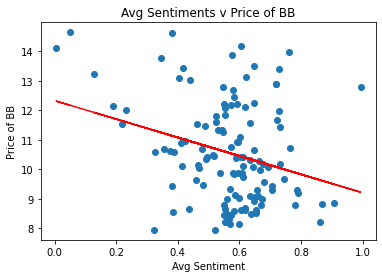

In [141]:
plot_corr('BB')

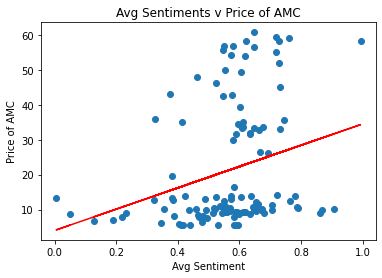

In [144]:
plot_corr('AMC')

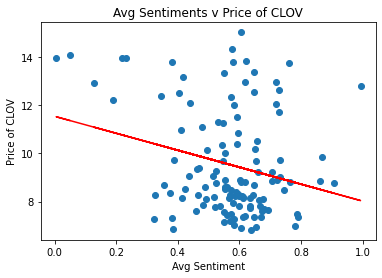

In [145]:
plot_corr('CLOV')

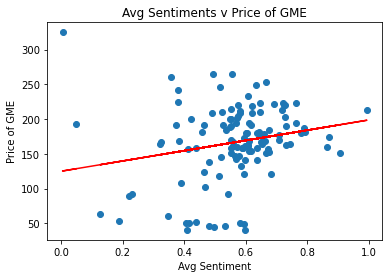

In [146]:
plot_corr('GME')

## 10. Proportion of WSB Thread Bodies by Meme Stock

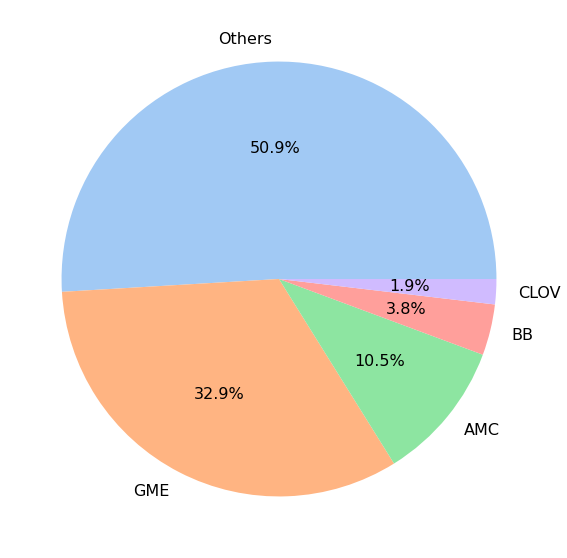

In [138]:
# Get overall count of columns
overall_count = reddit_wsb_daily[['count_body', 'count_body_gme', 'count_body_amc', 'count_body_bb', 'count_body_clov']].sum(axis = 0)

# Get remaining count of non-individual stocks
overall_count[0] -= sum(overall_count[1:5])

# Rename indices
overall_count.rename(index = {'count_body':'Others', 'count_body_gme':'GME', 'count_body_amc':'AMC', 'count_body_bb':'BB',
                              'count_body_clov':'CLOV'}, inplace = True)

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Plot pie chart
plt.figure(figsize = (15,10))
plt.pie(overall_count, labels = overall_count.index, colors = colors, autopct='%1.1f%%', textprops = {'fontsize': 16})
plt.show()

## 11. Multiple Linear Regression Analysis on Number of WSB Threads, Avg Sentiment vs Respective Stock Prices 

In [187]:
Regressor = LinearRegression()
data = reddit_meme_combined.dropna()

def plot_MLR(stock_name):
    df2 = pd.DataFrame()
    x = data[[('count_body_' + stock_name.lower()), ('compound_mean_body_' + stock_name.lower())]]
    y = data[(stock_name + ' Price')]
    df2[['Count', 'Avg']] = x
    df2[stock_name] = pd.Series(y)
    Regressor.fit(x,y)
    x_surf, y_surf = np.meshgrid(np.linspace(df2.Count.min(), df2.Count.max(), 100), 
                                 np.linspace(df2.Avg.min(), df2.Avg.max(), 100))
    onlyX = pd.DataFrame({'Count': x_surf.ravel(), 'Avg': y_surf.ravel()})
    fittedY = Regressor.predict(onlyX)
    fittedY = np.array(fittedY)

    fig = plt.figure(figsize = (20,10)) # Set figure size
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(df2[stock_name], df2['Count'], df2['Avg'], c = 'red', marker = 'o', alpha = 0.5)
    ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), color = 'b', alpha =0.3)
    ax.set_xlabel('Count')
    ax.set_ylabel('Avg Sentiments')
    ax.set_zlabel('Price')
    plt.title('Mlr Model for ' + stock_name + ' Price')
    plt.show()

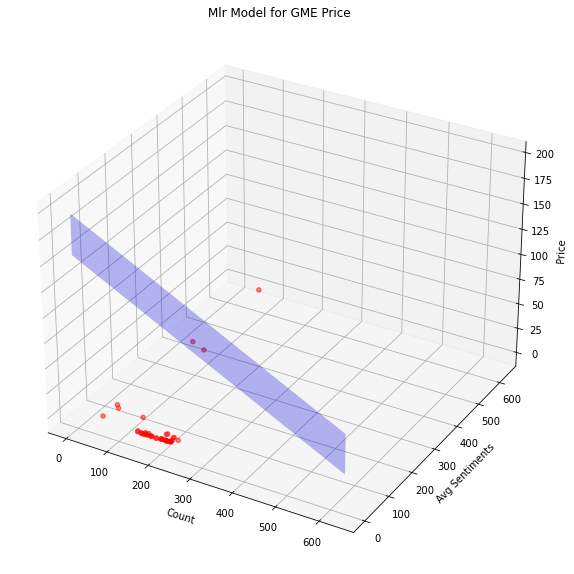

In [188]:
plot_MLR('GME')

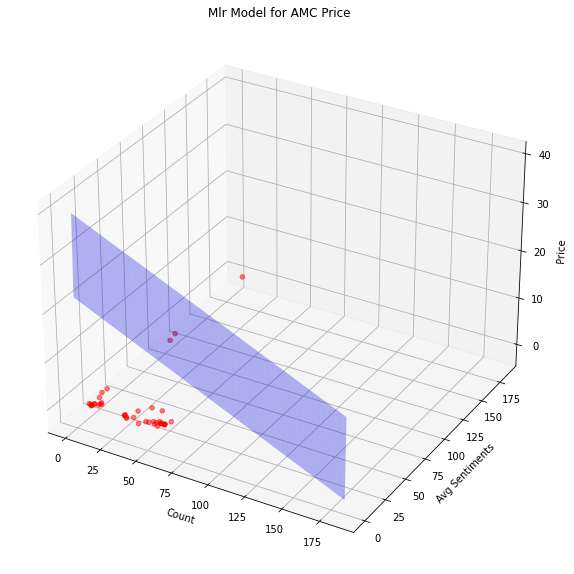

In [189]:
plot_MLR('AMC')

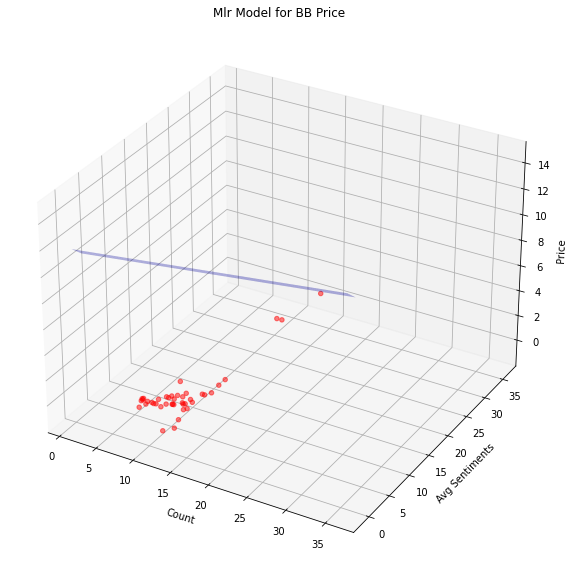

In [190]:
plot_MLR('BB')

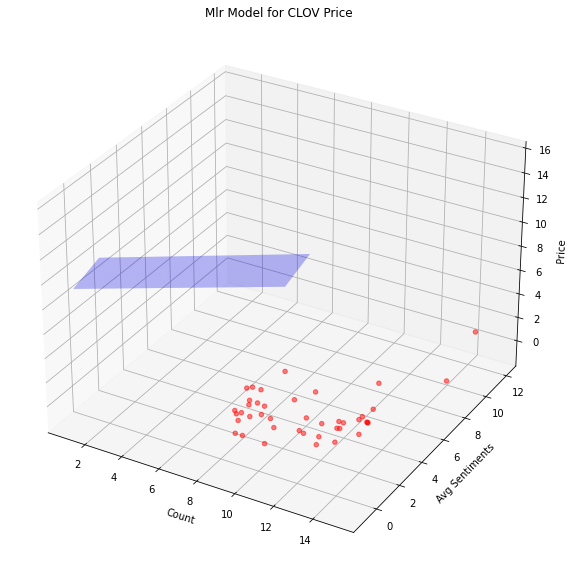

In [191]:
plot_MLR('CLOV')